In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import cloudpickle

In [69]:
# Load Dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

# Display the first few rows of the dataframe
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# Data Exploring

In [70]:
# Check for missing values in the DataFrame
missing_values = df_train.isnull().sum()

# Calculate the percentage of missing values
missing_percentage = (missing_values / len(df_train)) * 100

# Display the columns with missing values and their percentage
print(missing_percentage[missing_percentage > 0])
print(f"Total number of rows in df_train: {len(df_train)}")


fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64
Total number of rows in df_train: 188533


In [71]:
# Fill in Missing Values

def fix_missing(df):
    # set missing fuel values to Gasoline since it is most common
    df['fuel_type'] = df['fuel_type'].fillna('Gasoline')
    
    # assume that if entry was '-' or 'not supported' then the car was electric or something
    df['fuel_type'] = df['fuel_type'].replace(['–', 'not supported'], 'NA')

    # make ommisions of clean title or accident record its own category called 'missing'
    df['accident'] = df['accident'].fillna('None reported')
    df['clean_title'] = df['clean_title'].fillna('missing')
    # Convert the 'accident' column to binary: 1 for accident reported, 0 otherwise
    df['accident'] = df['accident'].apply(
        lambda x: 1 if x != 'None reported' else 0
    )
    # Convert clean title to by binary
    df['clean_title'] = df['clean_title'].apply(
        lambda x: 1 if x != 'missing' else 0
    )
    
    return df

# Apply the function to both train and test dataframes
df_train = fix_missing(df_train)
df_test = fix_missing(df_test)

Highest Price: 2954083
Lowest Price: 2000
Average Price: 43878.01617753921


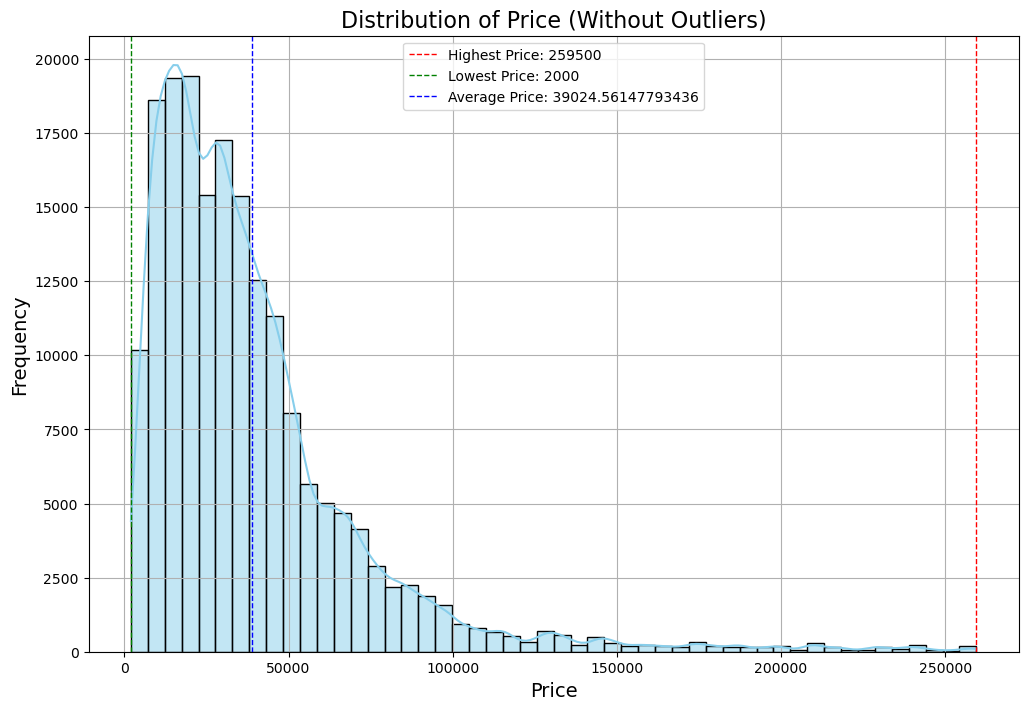

In [72]:
# Calculate highest, lowest, and average price
highest_price = df_train['price'].max()
lowest_price = df_train['price'].min()
average_price = df_train['price'].mean()

print(f"Highest Price: {highest_price}")
print(f"Lowest Price: {lowest_price}")
print(f"Average Price: {average_price}")

# Filter outliers to see them on the graph better
upper_bound = df_train['price'].quantile(0.99)
filtered_df = df_train[(df_train['price'] <= upper_bound)]

# Plot
plt.figure(figsize=(12, 8))
sns.histplot(filtered_df['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Price (Without Outliers)', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(filtered_df['price'].max(), color='red', linestyle='dashed', linewidth=1, label=f'Highest Price: {filtered_df["price"].max()}')
plt.axvline(filtered_df['price'].min(), color='green', linestyle='dashed', linewidth=1, label=f'Lowest Price: {filtered_df["price"].min()}')
plt.axvline(filtered_df['price'].mean(), color='blue', linestyle='dashed', linewidth=1, label=f'Average Price: {filtered_df["price"].mean()}')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# going to get rid of the outliers from the train set
df_train = df_train[(df_train['price'] <= 250000)]


In [74]:
print(f"Number of rows in df_train: {df_train.shape[0]}")
print(f"Number of unique entries in 'engine' column: {df_train['engine'].nunique()}")
df_train.tail()

Number of rows in df_train: 186513
Number of unique entries in 'engine' column: 1117


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,0,1,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,1,1,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,0,1,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,0,0,84900
188532,188532,Porsche,Macan Base,2016,59500,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,0,1,28995


In [75]:
import re

def extract_car_specs(entry):
    # Use regular expressions to find the numbers
    hp_match = re.search(r'(\d+\.?\d*)HP', entry)  # Matches "420.0HP"
    
    # Updated regex for liters: Matches "6.2L" or "2.0 Liter"
    l_match = re.search(r'(\d+\.?\d*)\s*(?:L|Liter)', entry, re.IGNORECASE)
    
    # Updated regex for cylinder count: Matches "6 Cylinder" or "V6"
    cyl_match = re.search(r'(?:(\d+)\s+Cylinder)|(?:V(\d+))', entry, re.IGNORECASE)

    #Check if all matches are found, otherwise print the entry
    # if not (hp_match or l_match or cyl_match):
    #     print(f"Issue with entry: {entry}")
    
    # Extract the values if matches are found
    hp = float(hp_match.group(1)) if hp_match else None
    L = float(l_match.group(1)) if l_match else None

    electric = 0

    if 'electric' in entry.lower():
        electric = 1
    
    turbo = 0

    if 'turbo' in entry.lower():
        turbo = 1


    if cyl_match:
        # Determine which group matched for cylinder count
        cylCount = int(cyl_match.group(1) or cyl_match.group(2))
    else:
        cylCount = None

    return hp, L, cylCount, electric, turbo


def process_engine_column(df):
    # Apply the extract_car_specs function to the specified column
    df[['hp', 'L', 'cylCount', 'electric', 'turbo']] = df['engine'].apply(lambda x: pd.Series(extract_car_specs(x)))    
    return df




process_engine_column(df_train)
process_engine_column(df_test)

# fill na columns (these are mostly the electric cars..)
df_train['hp'] = df_train['hp'].fillna(df_train['hp'].mean())
df_train['L'] = df_train['L'].fillna(df_train['L'].mean())
df_train['cylCount'] = df_train['cylCount'].fillna(df_train['cylCount'].mean())

df_test['hp'] = df_test['hp'].fillna(df_train['hp'].mean())
df_test['L'] = df_test['L'].fillna(df_train['L'].mean())
df_test['cylCount'] = df_test['cylCount'].fillna(df_train['cylCount'].mean())

df_train.head()



,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,L,cylCount,electric,turbo
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,1,4200,172.0,1.6,4.0,0.0,0.0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,1,4999,252.0,3.9,8.0,0.0,0.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,1,13900,320.0,5.3,8.0,0.0,0.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,1,45000,420.0,5.0,8.0,0.0,0.0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,0,1,97500,208.0,2.0,4.0,0.0,0.0


In [76]:
# get stuff out of the transmission column
num_unique_transmissions = df_train['transmission'].nunique()
print(f"Number of unique values in 'transmission' column: {num_unique_transmissions}")

# Print the unique transmission values and their counts
transmission_counts = df_train['transmission'].value_counts()
print(transmission_counts)

# for the transmisison i want to generate 3 cols
# one column for the speed
# on a col for of manual 
# a col for if automatic
def extract_car_transmission(entry):
    # Use regular expressions to find the speed
    speed_match = re.search(r'(\d+)', entry)
    speed = int(speed_match.group(1)) if speed_match else 8
    
    # Determine if the transmission is manual or automatic
    at = 0
    mt = 0

    manual_transmissions = ["M/T", "Manual", "Mt"]
    if any(manual in entry for manual in manual_transmissions):
        mt = 1
    else:
        at = 1
    
    return speed, mt, at

def process_transmission_column(df):
    # Apply the extract_car_specs function to the specified column
    df[['trans_speed', 'manual', 'automatic']] = df['transmission'].apply(lambda x: pd.Series(extract_car_transmission(x)))    
    return df

process_transmission_column(df_train)
process_transmission_column(df_test)


df_train.head()

Number of unique values in 'transmission' column: 52
transmission
A/T                                                   49714
8-Speed A/T                                           20383
Transmission w/Dual Shift Mode                        19064
6-Speed A/T                                           17998
6-Speed M/T                                           11938
7-Speed A/T                                           11016
Automatic                                             10506
8-Speed Automatic                                      8143
10-Speed A/T                                           7963
9-Speed A/T                                            3807
5-Speed A/T                                            3208
10-Speed Automatic                                     3102
6-Speed Automatic                                      2779
4-Speed A/T                                            2542
5-Speed M/T                                            2408
9-Speed Automatic                 

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,L,cylCount,electric,turbo,trans_speed,manual,automatic
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,1,4200,172.0,1.6,4.0,0.0,0.0,8,0,1
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,1,4999,252.0,3.9,8.0,0.0,0.0,8,0,1
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,1,13900,320.0,5.3,8.0,0.0,0.0,8,0,1
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,1,45000,420.0,5.0,8.0,0.0,0.0,8,0,1
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,0,1,97500,208.0,2.0,4.0,0.0,0.0,7,0,1


Other things i need to do:
1. Fill in Missing Values
    - fuel type
    - accident
    - clean title
2. get rid of rare models / brands
3. create categorical brand-model values.
4. change model year to age
4.5 might change trasmission to only diff between at and manual.
5. other categorical values
    - int_color
    - ext_color
    - Transmission Done
6. heapmap for numerical features
7. measure correlation for categoricals. 

In [77]:
# Calculate model age
df_train['model_age'] = 2025 - df_train['model_year']
df_test['model_age'] = 2025 - df_test['model_year']

# merege brand and model columns ?

# Display the first few rows to verify the changes
print(df_train.columns)
df_train.head()

# drop origional columns model year
df_train.drop('model_year', axis=1, inplace=True)
df_test.drop('model_year', axis=1, inplace=True)

numerical = ['mileage', 'hp', 'L', 'cylCount', 'trans_speed', 'model_age']

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'hp', 'L', 'cylCount', 'electric', 'turbo', 'trans_speed',
       'manual', 'automatic', 'model_age'],
      dtype='object')


In [78]:

# Print the unique values and their counts for 'ext_col' and 'int_col' columns
# Set display options to show the full DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_test['ext_col'] = df_test['ext_col'].replace(['–'], 'Black')
df_test['int_col'] = df_test['int_col'].replace(['–'], 'Black')
df_train['ext_col'] = df_train['ext_col'].replace(['–'], 'Black')
df_train['int_col'] = df_train['int_col'].replace(['–'], 'Black')

# Print the unique values and their counts for 'ext_col' and 'int_col' columns
print(df_train['ext_col'].value_counts())
print(df_train['int_col'].value_counts())

ext_col
Black                                      48523
White                                      43517
Gray                                       25045
Silver                                     16914
Blue                                       14458
Red                                         9795
Green                                       2658
Gold                                        1663
Brown                                       1154
Orange                                      1121
Beige                                       1080
Yellow                                       959
Bright White Clearcoat                       747
Diamond Black                                697
Agate Black Metallic                         626
Summit White                                 505
Silver Ice Metallic                          448
Mythos Black Metallic                        411
Midnight Black Metallic                      375
Granite Crystal Clearcoat Metallic           361
Purple      

here is where i should do more data analysis for different columns

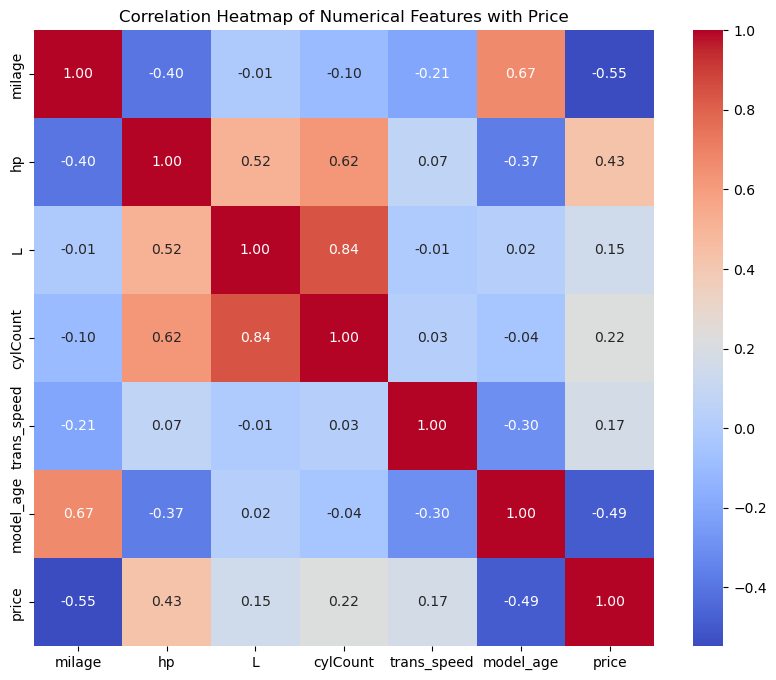

In [79]:
#HeatMap for Numerical Columns 

numerical = ['milage', 'hp', 'L', 'cylCount', 'trans_speed', 'model_age']
columns_for_correlation = numerical + ['price']

# Compute the correlation matrix
correlation_matrix = df_train[columns_for_correlation].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features with Price")
plt.show()

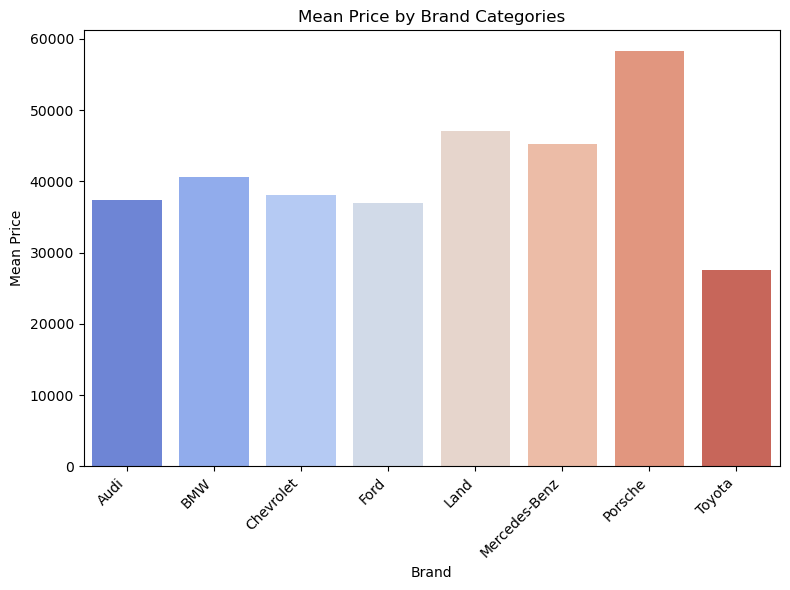

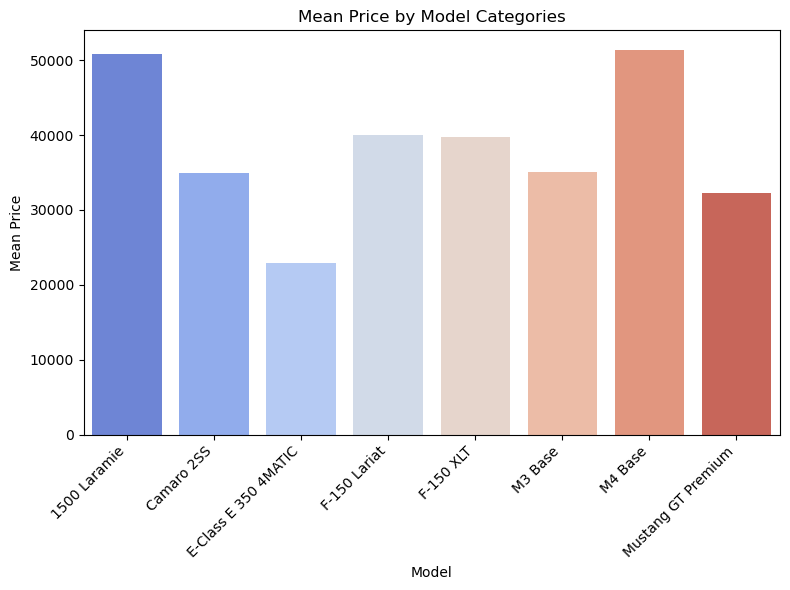

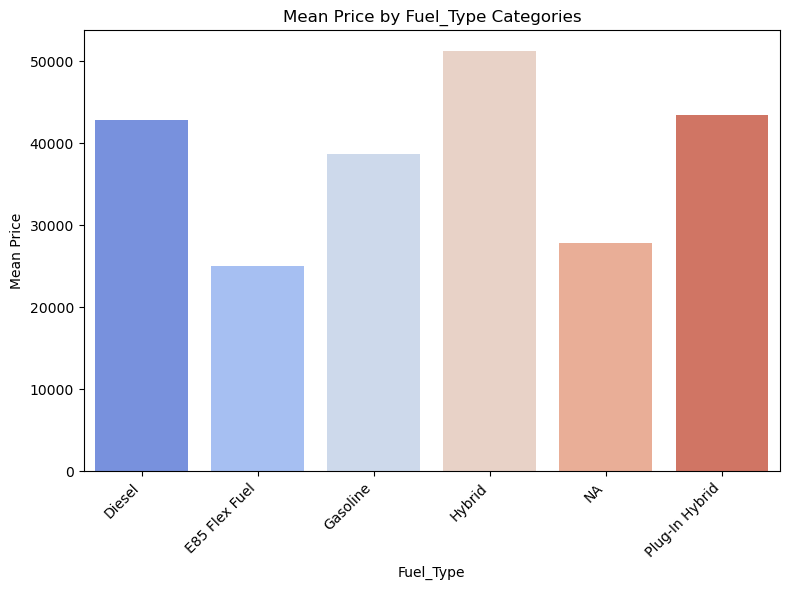

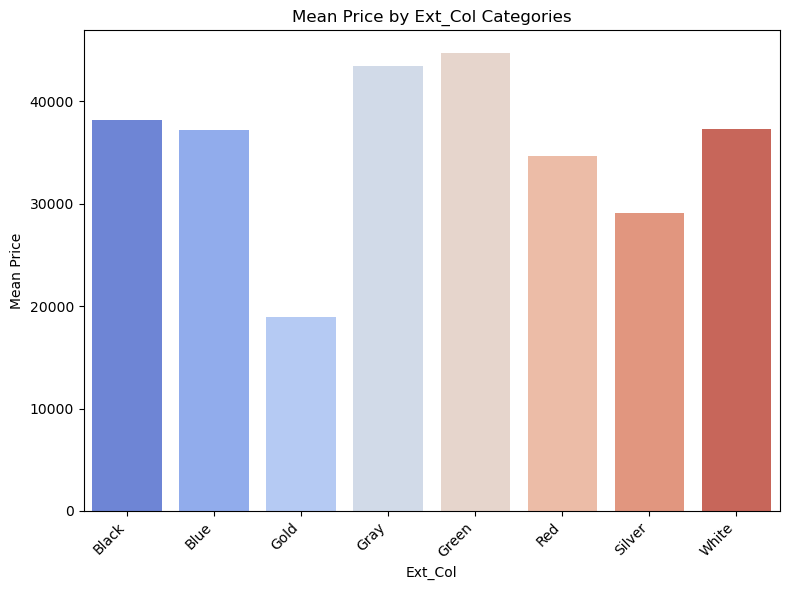

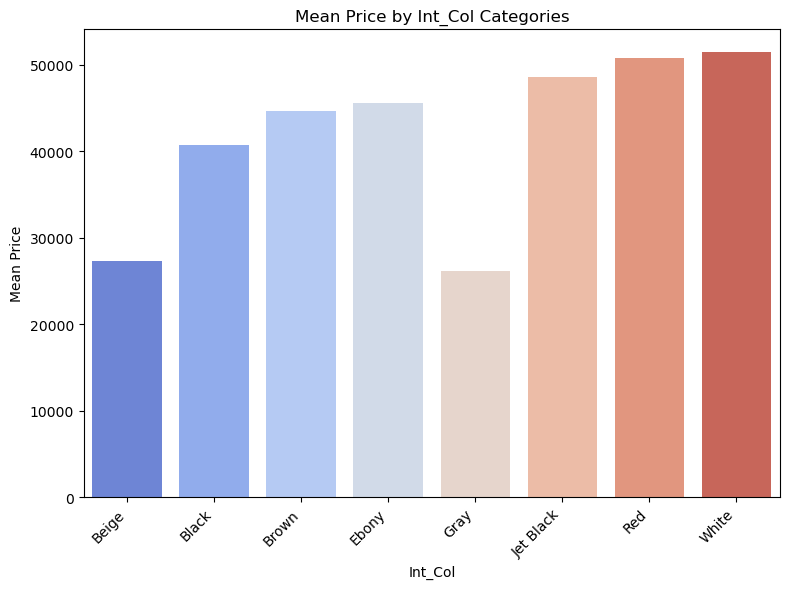

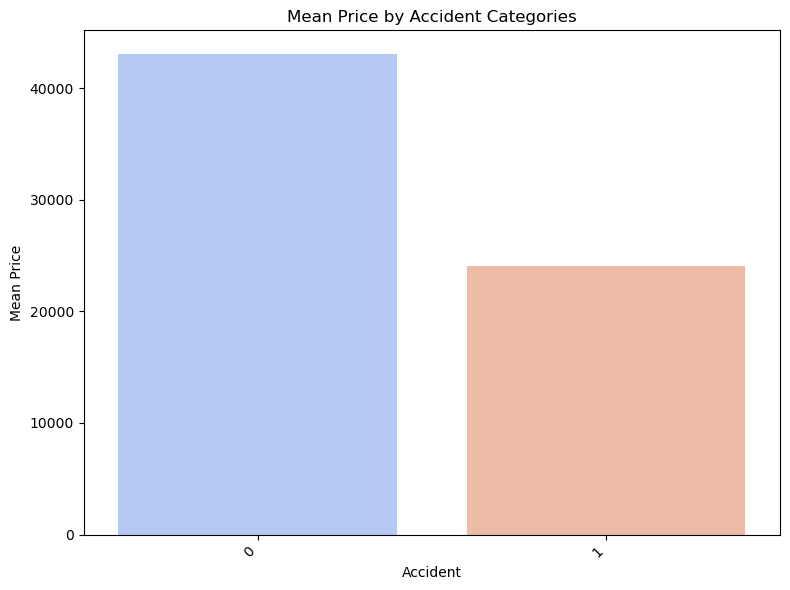

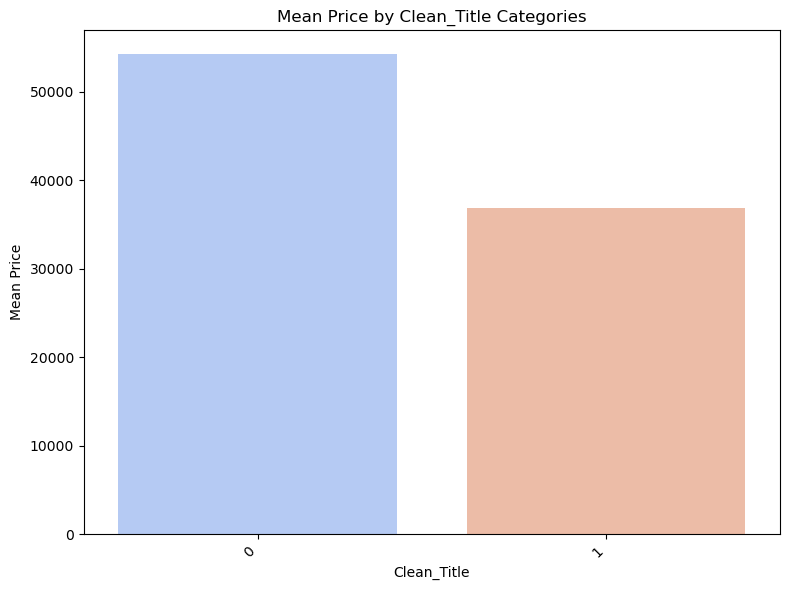

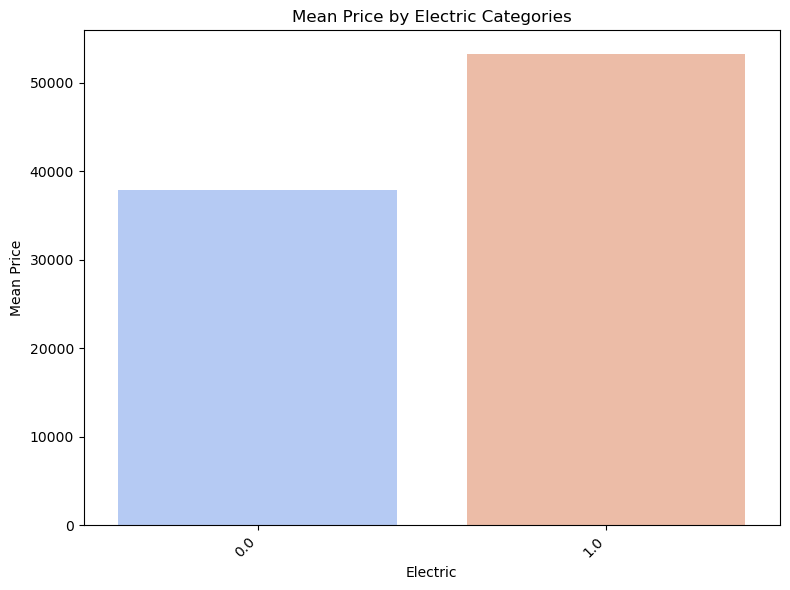

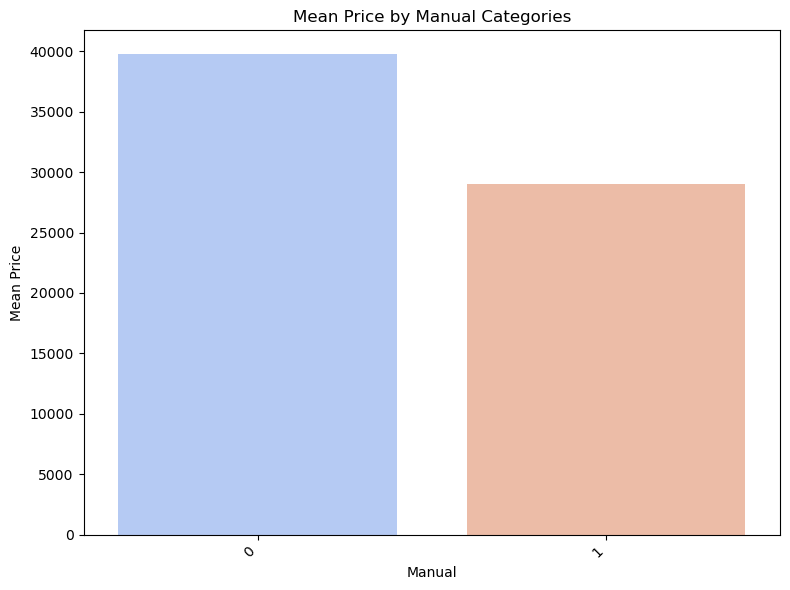

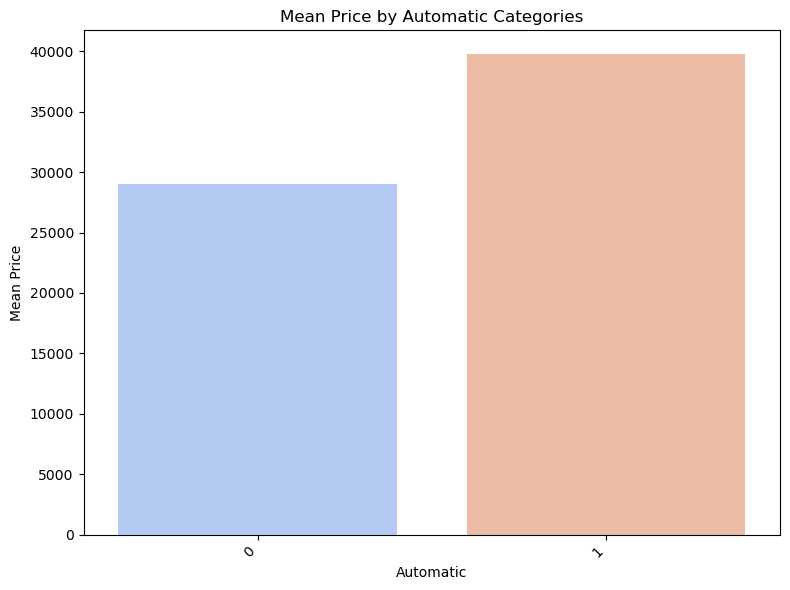

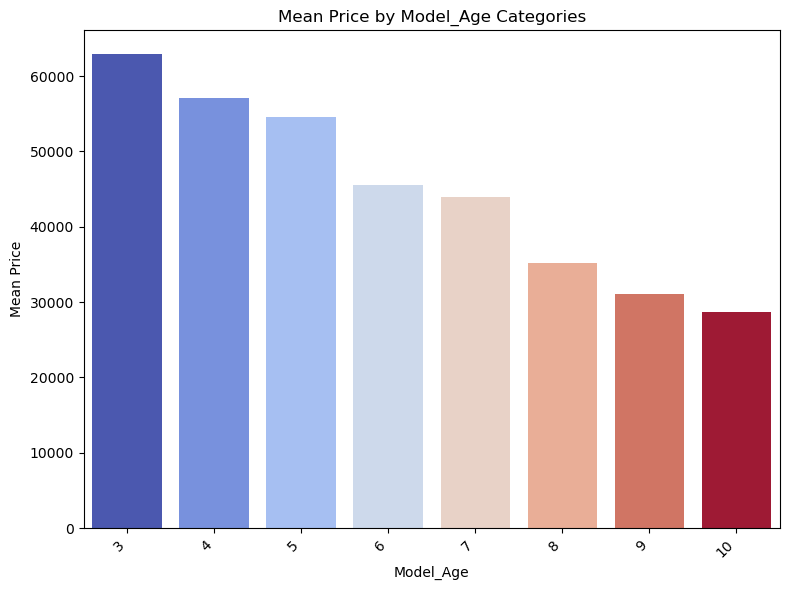

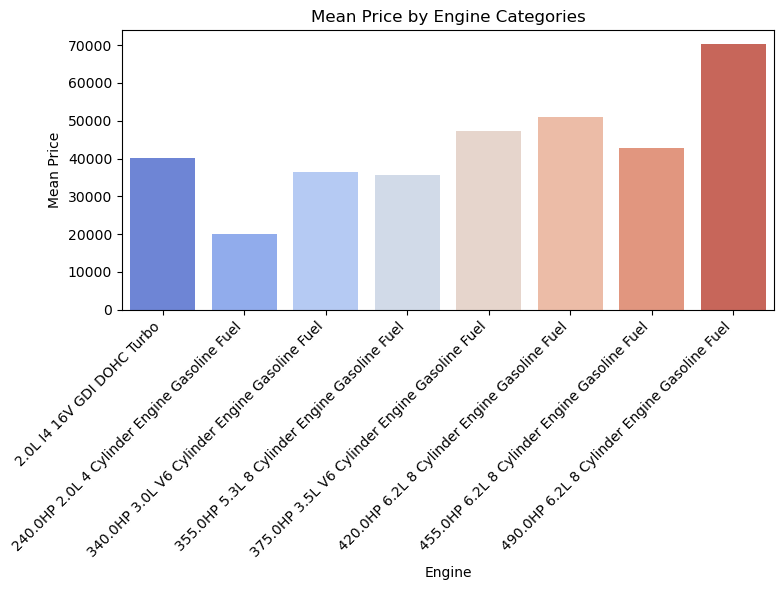

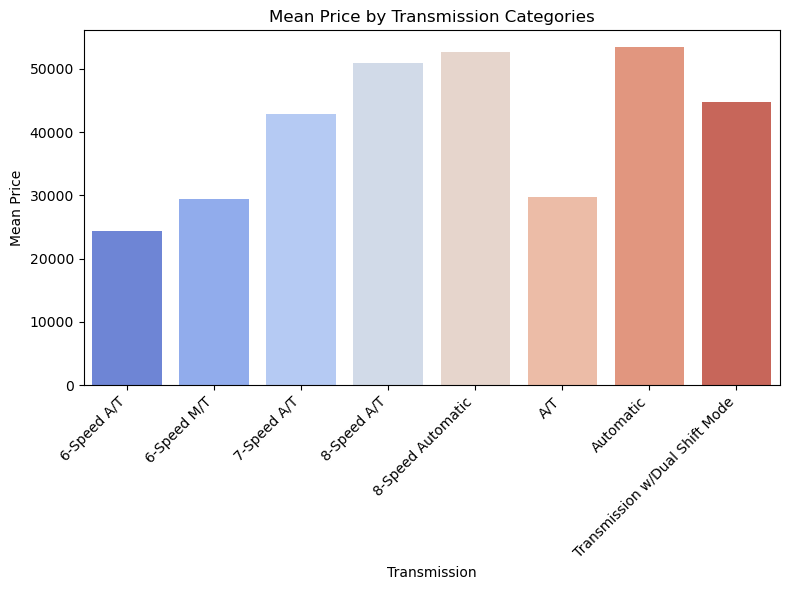

In [80]:
# bar graphs for all columns
# Define the categorical columns
categorical_columns = ['brand', 'model', 'fuel_type', 'ext_col', 'int_col', 
                       'accident', 'clean_title', 'electric', 'manual', 'automatic', 'model_age', 'engine', 'transmission']

# Function to select the top 8 most common values for a categorical column and calculate the mean price
def top_categories_correlation(df, col, target='price', top_n=8):
    if df[col].nunique() <= 2:  # For binary columns (e.g., True/False)
        mean_prices = df.groupby(col)[target].mean()
    else:
        top_categories = df[col].value_counts().nlargest(top_n).index
        filtered_data = df[df[col].isin(top_categories)]
        mean_prices = filtered_data.groupby(col)[target].mean()
    return mean_prices

# Generate a bar plot for each categorical column
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    correlation_data = top_categories_correlation(df_train, col, target='price')
    
    # Convert correlation data to a DataFrame for easier plotting with hue
    correlation_df = correlation_data.reset_index()
    correlation_df.columns = [col, 'Mean Price']
    
    sns.barplot(
        data=correlation_df,
        x=col,
        y='Mean Price',
        hue=col,  # Assign the x variable to hue
        dodge=False,  # Prevent splitting bars for hue
        palette="coolwarm",
        legend=False  # Suppress legend since hue matches x
    )
    plt.title(f"Mean Price by {col.title()} Categories")
    plt.xlabel(col.title())
    plt.ylabel("Mean Price")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [81]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['brand', 'model', 'fuel_type', 'ext_col', 'int_col', 'engine', 'transmission']

most_common_values = {col: df_train[col].mode()[0] for col in df_train.columns}
category_means = {}
for cat in categorical_features:
    # Group by the category and calculate mean price
    cat_means = df_train.groupby(cat)['price'].mean().to_dict()
    
    # Add the most common value (mode) for the column as the fallback for unknown categories
    most_common_value = most_common_values[cat]  # Get the most common value
    cat_means['__most_common__'] = cat_means.get(most_common_value, df_train['price'].mean())  
    
    # Save the means for this category
    category_means[cat] = cat_means

def target_encode_with_saved_means(df, cat_col, means_dict):
    # Map the categories to their means, using the overall mean for unknown categories
    most_common = means_dict.get('__most_common__', 0)
    df[cat_col] = df[cat_col].map(means_dict).fillna(most_common)

for cat in categorical_features:
    target_encode_with_saved_means(df_test, cat, category_means[cat])
    target_encode_with_saved_means(df_train, cat, category_means[cat])



# Save the category means using cloudpickle
with open('category_means.pkl', 'wb') as f:
    cloudpickle.dump(category_means, f)

# Save the most common values using cloudpickle
with open('most_common_values.pkl', 'wb') as f:
    cloudpickle.dump(most_common_values, f)

print("Category means and most common values saved successfully!")




# Display the modified DataFrames
df_train.head()



Category means and most common values saved successfully!


,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,L,cylCount,electric,turbo,trans_speed,manual,automatic,model_age
0,0,17162.015977,12832.716263,213000,38700.354537,11430.680233,29743.796697,34744.785193,26159.701813,0,1,4200,172.0,1.6,4.0,0.0,0.0,8,0,1,18
1,1,29530.615735,12663.379310,143250,38700.354537,12183.759494,29743.796697,29110.790233,27271.190868,1,1,4999,252.0,3.9,8.0,0.0,0.0,8,0,1,23
2,2,38117.520353,23779.677419,136731,25036.580382,17786.462324,29743.796697,37195.745331,26159.701813,0,1,13900,320.0,5.3,8.0,0.0,0.0,8,0,1,23
3,3,46702.695698,48915.842105,19500,38700.354537,42265.590426,44813.121958,38211.094965,40734.068181,0,1,45000,420.0,5.0,8.0,0.0,0.0,8,0,1,8
4,4,45250.472047,53449.460630,7388,38700.354537,35573.922741,42817.590959,38211.094965,27271.190868,0,1,97500,208.0,2.0,4.0,0.0,0.0,7,0,1,4


In [82]:
from sklearn.base import BaseEstimator, TransformerMixin
# hyper params
class SelectColumns( BaseEstimator, TransformerMixin ):
    # pass the function we want to apply to the column 'SalePrice’
    def __init__( self, columns ):
        self.columns = columns
        # don't need to do anything
    def fit( self, xs, ys, **params ):
        return self
    # actually perform the selection
    def transform( self, xs ):
        return xs[ self.columns ]

In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming df_train is already defined and preprocessed
# Split data into features and target
X = df_train.drop(['price', 'id'], axis=1)
y = df_train['price']

all_columns = [col for col in df_train.columns if col not in ['price', 'id']]
subset_columns_1 = [col for col in all_columns if col not in ['L', 'trans_speed', 'cylCount']]
subset_columns_2 = [col for col in all_columns if col not in ['L', 'trans_speed']]
subset_columns_3 = [col for col in all_columns if col not in ['L']]
subset_columns_4 = [col for col in all_columns if col not in ['manual']]
subset_columns_5 = [col for col in all_columns if col not in ['turbo']]


# Define the pipeline
pipeline = Pipeline([
    ('select_columns', SelectColumns(['brand', 'model'])),  # Dynamically select columns
    ('scaler', StandardScaler()),  # Standardize the features
    ('regressor', RandomForestRegressor(random_state=42))  # Regression model
])

# Define the parameter grid for GridSearchCV
# param_grid = {
#     'select_columns__columns': [all_columns, subset_columns_1, subset_columns_2, subset_columns_3, subset_columns_4, subset_columns_5],
#     'regressor__n_estimators': [100, 200, 250],
#     'regressor__max_depth': [10, 20, 25],
#     'regressor__min_samples_split': [2, 5, 7],
#     'regressor__min_samples_leaf': [1, 2, 3]
# }
param_grid = {
    'select_columns__columns': [all_columns],
    'regressor__n_estimators': [250],
    'regressor__max_depth': [20],
    'regressor__min_samples_split': [7],
    'regressor__min_samples_leaf': [3]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the same dataset (since we are not splitting)
y_pred = best_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Save the model using cloudpickle
with open('best_model.pkl', 'wb') as f:
    cloudpickle.dump(best_model, f)

print("Best model saved successfully!")

# Print the RMSE
print(f'Root Mean Squared Error: {rmse}')

# Print the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

Best model saved successfully!
Root Mean Squared Error: 17283.561269619444
Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 7, 'regressor__n_estimators': 250, 'select_columns__columns': ['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'hp', 'L', 'cylCount', 'electric', 'turbo', 'trans_speed', 'manual', 'automatic', 'model_age']}


In [46]:
X_test = df_test.drop('id', axis=1)

# Predict on df_test
y_pred = best_model.predict(X_test)

# Create a DataFrame for submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'price': y_pred
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission DataFrame
print(submission.head())

       id         price
0  188533  16069.657883
1  188534  75396.793318
2  188535  49178.320270
3  188536  29151.366062
4  188537  26864.353518


# things to do next


then heatmap for numericals...
some graphs for categoricals...

then make a new column selection pass

then export the best model
make a fast api
make a javascript front end to input params.

